# Kolmogorov Smirnov Two Sample Test

We run a two-sided KS test to see if two datasets (i.e. two methods of generating stochastic rainfall) were drawn from the sample underlying distribution. We use a parametric and non-parametric approach to estimate rainfall:
- Parametric: generate rainfall frome exponential distribution
- Non-parametric: use empirical rainfall distribution to draw from a normal distribution (check)

We use a KS test because it is non-parametric and distribution agnostic, and can be used to compare two samples of data. Our hypotheses are:
- `H_0` (null hypothesis): Two samples (datasets) come from the same distribution.
- `H_1` (altnerative hypothesis): Two samples are from different distributions. 

And then use the Test statistic, `D`, or level of significance, `alpha`, to determine the result. 

## Table of Contents
Notebook is divided into three parts:
1. Part 1: [Generate non-parametric rainfall](#part1)
2. Part 2: [Import exponential rainfall data](#part2)
3. Part 3: [Run KS Two Sample Test](#part3)

In [23]:
# import packages, objects, set module path
from math import exp
import numpy as np
import pandas as pd
from numpy.random import exponential, uniform
from dateutil.relativedelta import *
import scipy.stats as st
from datetime import timedelta, datetime
import os
import sys
import glob
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from farm import Climate
from farm.climate import make_climate_parameters

## Get non-parametric estimation of rainfall  <a class="anchor" id="part1"></a>

Use code from `make_climate_parameters` function to import rainfall.

In [24]:
station='OL JOGI FARM'
data_file="../data/CETRAD/CETRAD_rainfall.csv"
year_min=30
interval='dekad'

# Prepare the CETRAD dataset.
df = pd.read_csv(data_file)  # Read in the raw csv data.

# Step 1. Convert text strings into datetime objects.
format = '%m/%d/%y' # Column RDate has data in M/D/YY
df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

# 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
# Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
# We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
# their value. This requires using the relativedelta function, which handles weird stuff like leap years.
df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

# Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
df['Year'] = [dt.year for dt in df['Datetime']]
df['Month'] = [dt.month for dt in df['Datetime']]
df['Week'] = [dt.week for dt in df['Datetime']]
df['Dekad'] = df['Datetime'].dt.dayofyear//10+1

n_years = len(df['Year'].unique())

# Step 4. Use the Datetime values as the index for this dataframe.
df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

# Step 5.  Delete the old RDate column, which we no longer need. 
# We will keep the Datetime column, in case we need it later.
df = df.drop(['RDate'], axis=1)

columns = [station] + ['Year', 'Month', 'Week', 'Dekad', 'Datetime']
rainfall = df[columns]

In [26]:
rainfall

,OL JOGI FARM,Year,Month,Week,Dekad,Datetime
Datetime,,,,,,
1934-01-01,NaN,1934,1,1,1,1934-01-01
1934-01-02,NaN,1934,1,1,1,1934-01-02
1934-01-03,NaN,1934,1,1,1,1934-01-03
1934-01-04,NaN,1934,1,1,1,1934-01-04
1934-01-05,NaN,1934,1,1,1,1934-01-05
...,...,...,...,...,...,...
2016-11-27,NaN,2016,11,47,34,2016-11-27
2016-11-28,NaN,2016,11,48,34,2016-11-28
2016-11-29,NaN,2016,11,48,34,2016-11-29


### Test code for generating rainfall using non-parametric approach

These are the steps:
1. Step 1: Sort X {x_0....x_n} from small to large
2. Step 2: Draw random number, u, from uniform distribution {0,1}
3. Step 3: Get sample: X [u*len(x)] and round to an integer
4. Step 4: Locate that rainfall sample by index
5. Step 5: Generate 365 integer numbers 
6. Step 6: Get rainfall for those integer numbers
7. Step 7: Don't want it to rain all of the time, only set rainfall days based on lambda

### Generate rainfall for 10,000 seasons

Rather than using the steps above and a for-loop we can run what's below much more quickly.

In [27]:
# Step 1: Sort X {x_0....x_n} from small to large
rain_days = rainfall.loc[rainfall['OL JOGI FARM'] > 0]
x = pd.DataFrame(rain_days['OL JOGI FARM']).sort_values(by='OL JOGI FARM').values.tolist()
x = pd.DataFrame(x)

# Note, if we want to run this for certain months of the year and not the full calendar year, then
# need to change both the lambdas that are running and the x values

no_rain = len(x)-1
lambdas = s0_climate.lambda_r
n_lambdas = len(lambdas)
nsims = 10000
pvals = np.random.uniform(low=0.0, high=1.0, size=nsims*n_lambdas)
data = np.round(np.random.uniform(low=0.0, high=1.0, size=nsims*n_lambdas)*no_rain)
lambda_list = np.array(([lambdas]*nsims)).flatten()
amounts = x.iloc[data]
rf = (pvals<lambda_list).astype(int)*amounts[0]         
final_rf = rf[rf != 0].values

In [28]:
# all of the rainfall data
x.iloc[data]

# rainfall data excluding zeroes
final_rf
onp = final_rf
print('how many values using the non-parametric approach for generating rainfall', len(onp))

how many values using the non-parametric approach for generating rainfall 583639


## Grab rainfall (exponential) from simulations <a class="anchor" id="part2"></a>

Need to create alternative simulations that have 365 days worth of data. Might be worth doing this in this notebook even.

In [29]:
# Import in the data
n_sim = 10000
no_sims = np.arange(0,n_sim)

files = glob.glob('../output/final/full_year/*.csv')
output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)

output[99]
len(output) # Check that there are 10,000 seasons

10000

The output is time series with all of the variables (kc, LAI, etc.. ). We want just the rainfall.

**Assumption**: Rounding the parametric data here. It provides the same result as not rounding, but runs much faster.

In [30]:
output_rf = np.array([df['R'] for df in output])
output_p = pd.DataFrame.from_records(output_rf)
#op_notrounded = np.array(pd.melt(output_p)['value'])
op = np.round(np.array(pd.melt(output_p)['value']), decimals=1) # let's round to the first decimal place
op = op[op != 0]
#op_notrounded = op_notrounded[op_notrounded != 0]

What's the difference in length between the two datasets?

In [31]:
print(len(op), len(onp)) #, len(op_notrounded))

580391 583639


## Do KS test  <a class="anchor" id="part3"></a>

For the KS two sample test, we assume two empirical distributions and then take the difference between the two. The beauty in this test lies the fact that we do not need to know or make any assumptions about the underlying distributions. 

Notes and code from here: [KS for Two Samples](https://towardsdatascience.com/when-to-use-the-kolmogorov-smirnov-test-dd0b2c8a8f61)

In order to compare the two datasets, we need to do the following:
1. Order each sample
2. Cat into one sorted array
3. Compute the observed CDFs of the two samples
4. Compute the maximum absolute difference, `D_n`
5. Compare against `D_crit`

In [32]:
# Kelly's method

def cdf(values):
    """ Defines function to compute cumulative distribution function.
        Input one sample of data. Returns the unique values and cdf.
    """
    sorted_values=np.sort(values)
    unique_values=np.unique(sorted_values)
    cdf_np=[]
    num_obs = len(sorted_values)
    for i,value in enumerate(unique_values):
        cdf_np.append(np.argmax(value==sorted_values)/num_obs)
    return unique_values, cdf_np

In [33]:
print(min(onp), min(op)) # smallest numbers look okay
print(max(onp), max(op)) # largest numbers are very different

0.2 0.1
78.4 144.4


In [34]:
# sort samples from non-parametric method (sample a)
samp_onp = np.sort(onp); samp_onp

# sort samples from original method, exponential (sample b)
#samp_op_nr = np.sort(op_notrounded)
samp_op = np.sort(op); samp_op

array([1.000e-01, 1.000e-01, 1.000e-01, ..., 1.408e+02, 1.421e+02,
       1.444e+02])

In [35]:
x_onp, y_onp = cdf(samp_onp)
x_op, y_op = cdf(samp_op)

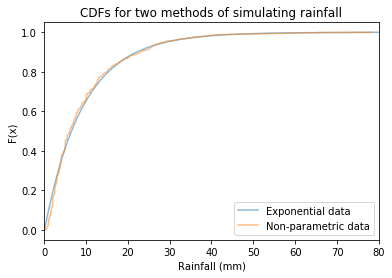

In [36]:
plt.plot(x_op, y_op, label='Exponential data', alpha=0.5)
plt.plot(x_onp, y_onp, label='Non-parametric data', alpha=0.5)

plt.xlabel('Rainfall (mm)')
plt.ylabel('F(x)')

plt.legend()
plt.title('CDFs for two methods of simulating rainfall')
plt.xlim(0,80)
plt.savefig('cdfs.png', dpi=600)

Run the statistics on it. Two-sided KS test: [ks_2samp method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp) in scipy.

Additional info from: https://sites.google.com/a/ucsc.edu/krumholz/teaching-and-courses/ast119_w15/class-10

The `ks_2samp` method returns a tuple: first is D, maximum difference between the CDF of the input data and the model CDF. The second is the p-value, i.e. the probability that if the data was actually drawn from the proposed CDF, then the resulting value of D would have been as/larger than the one we measured

E.g., D = 0.0305, p-value 0.3, then 30% of the time we would expect a value of D as large as the one actually got even if the data had been drawn from the proposed distribution. There cannot reject the hypothesis that the data were drawn from the proposed distribution

**In this case**, we can reject the null hypothesis since the p-value is well below 1%. Therefore the two datasets come from different distributions. I.e., it is probable that the two distributions are different. 

There are two options for interpreting the result: 1. Use p-level as level of significant where p < 0.01 is highly significant or 2. Use statistic value given by python and compare it to the [KS-test critical value table](https://sparky.rice.edu//astr360/kstest.pdf) according to sample size. When statistic value is greater than the critical value, then the two distributions are different.

In [21]:
# Run the statistics

# first argument is the dataset, the second is the second dataset
st.ks_2samp(op, onp)

Ks_2sampResult(statistic=0.07036848657981756, pvalue=0.0)

In [22]:
# What is the D_crit value for the two sample sizes
n1 = len(op)
n2 = len(onp)

# Use alpha = 0.05
alpha = 0.05
c_alpha = 1.36

D_crit = c_alpha*np.sqrt((n1+n2)/(n1*n2))

print(D_crit)

0.002519897559309453


The statistics value (~0.07) is greater than the critical value (0.002) so the two distributions are different.

## Take-aways from this work:
- when sample sizes are sufficiently large there are small effect sizes and thus very small p-values. P-values can't answer the question "are these distributions similar." For the KS test any small difference in distributions will be significant at large sample sizes. See discussion [here](https://stats.stackexchange.com/questions/349618/ks-test-always-significant), [here](https://stats.stackexchange.com/questions/2516/are-large-data-sets-inappropriate-for-hypothesis-testing), and [here](https://stats.stackexchange.com/questions/125750/sample-size-too-large).

- so, instead we have to ask: what are we trying to get out of this analysis? What is the magnitude of difference between the two distributions?
- what we're seeing is that the data from the simulations (fit to an exponential distribution) overestimates small rainfall events (between 0-5mm) compared to the non-parametric approach. And underestimates rainfall events between 5-20mm compared to non-parametric approach. For rainfall events between 20-25mm, the simulations data overestimates these events. The two methods perform similarly for events greater than 30mm.

- could consider plotting a P-P plot as mentioned [here](https://stats.stackexchange.com/questions/406940/why-does-the-ks-test-function-give-a-p-value-of-0-for-these-two-samples) or a QQ plot, see [here](https://stats.stackexchange.com/questions/74434/kolmogorov-smirnov-test-strange-output).

## Old code:

In [4]:
# Step 1: Sort X {x_0....x_n} from small to large
rain_days = rainfall.loc[rainfall['OL JOGI FARM'] > 0]
x = pd.DataFrame(rain_days['OL JOGI FARM']).sort_values(by='OL JOGI FARM').values.tolist()
x = pd.DataFrame(x); print('number of rainfall events, len(x):',len(x))

number of rainfall events, len(x): 1858


In [5]:
x[0].max()
#x[0].min()

78.4

In [6]:
# Step 2: Draw random number, u, from uniform distribution {0,1}
u = np.random.uniform(low=0.0, high=1.0, size=None); print('random number, u:',u)

random number, u: 0.9123453334661172


In [7]:
# Step 3: Get sample: X [u*len(x)] and round to an integer
ix = int(u*len(x)); print('index for sample, ix:',ix)

index for sample, ix: 1695


In [8]:
# Step 4: Locate that rainfall sample by index
x.iloc[ix,0] # row ix, column 0

24.9

In [9]:
# Step 5: Generate 365 integer numbers 
data = []

for i in np.arange(1,366):
    u = np.random.uniform(low=0.0, high=1.0, size=None)
    ix = int(u*len(x))
    x.iloc[ix,0] 
    data.append(ix)

# Step 6: Get rainfall for those integer numbers
rf = x.iloc[data]

# Step 7: Don't want it to rain all of the time
t_sim=365

# Force doy to be in [1,365]:
doy_start=1
doys = np.arange(doy_start, doy_start + t_sim)
while (doys - 365 > 0).any() == True:
        doys = doys - 365 * ((doys - 365) > 0)
#amounts = [exponential(scale=s0_climate.alpha_r[doy-1], size=1)[0] for doy in doys]
amounts= rf[0].to_list()

s0_climate = Climate(data_file=data_file, station=station, interval=interval)

In [10]:
rain_days = [(uniform(low=0, high=1, size=1) <= s0_climate.lambda_r[doy-1] ).astype(int) for doy in doys]
final = np.multiply(amounts, [v[0] for v in rain_days])
print('there are',len(final),' days of rainfall')
print('total annual rainfall for one simulation is: ',final.sum())

there are 365  days of rainfall
total annual rainfall for one simulation is:  606.7
